# Notebook 01: Problem Understanding & Data Overview

## Project Title
AIM ML Capstone – Fair & Explainable Recommendation System using MovieLens 1M

## Objective
This notebook covers:
- Business and data science problem framing
- Definition of the machine learning task
- Overview of the MovieLens 1M dataset
- Initial data inspection and data dictionary

This notebook maps to:
- Capstone Step 1: Problem Understanding & Framing
- Capstone Step 2: Data Collection & Understanding


In [16]:
import pandas as pd

# Load MovieLens 1M data
movies = pd.read_csv(
    'movies.dat',
    sep='::',
    engine='python',
    names=['movie_id', 'title', 'genres'],
    encoding='latin-1'
)

ratings = pd.read_csv(
    'ratings.dat',
    sep='::',
    engine='python',
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)

users = pd.read_csv(
    'users.dat',
    sep='::',
    engine='python',
    names=['user_id', 'gender', 'age', 'occupation', 'zip_code']
)

movies.head(), ratings.head(), users.head()


(   movie_id                               title                        genres
 0         1                    Toy Story (1995)   Animation|Children's|Comedy
 1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
 2         3             Grumpier Old Men (1995)                Comedy|Romance
 3         4            Waiting to Exhale (1995)                  Comedy|Drama
 4         5  Father of the Bride Part II (1995)                        Comedy,
    user_id  movie_id  rating  timestamp
 0        1      1193       5  978300760
 1        1       661       3  978302109
 2        1       914       3  978301968
 3        1      3408       4  978300275
 4        1      2355       5  978824291,
    user_id gender  age  occupation zip_code
 0        1      F    1          10    48067
 1        2      M   56          16    70072
 2        3      M   25          15    55117
 3        4      M   45           7    02460
 4        5      M   25          20    55455)

## Business Problem Statement

In digital platforms such as streaming services and eCommerce marketplaces,
users are exposed to an overwhelming number of choices. Poor personalization
leads to lower user engagement, reduced satisfaction, and revenue loss.

The business objective is to build a recommendation system that:
- Accurately predicts user preferences
- Improves content discovery
- Ensures fairness across demographic groups
- Provides explainable recommendations

From a data science perspective, this problem is addressed using
collaborative filtering techniques.


## ML Task Type & Success Metrics (Capstone Step 1)

### Task Type
This is a **recommendation** problem (collaborative filtering) using explicit feedback (1–5 star ratings).

### Technical Success Metrics
Primary:
- **RMSE** (rating prediction error)

Ranking/Top-K (user experience):
- **Precision@K**
- **Recall@K**
- **NDCG@K**

### Business KPIs (proxy)
- Higher click-through / watch time / purchase conversion
- Reduced churn through improved personalization
- Increased catalog discovery (long-tail exposure)

**Success definition:** Achieve strong RMSE while maintaining good Top-K ranking metrics, and verify no large performance gaps across demographic groups during fairness auditing.


In [17]:
import pandas as pd

movies = pd.read_csv(
    "movies.dat",
    sep="::",
    engine="python",
    names=["movie_id", "title", "genres"],
    encoding="latin-1"
)

ratings = pd.read_csv(
    "ratings.dat",
    sep="::",
    engine="python",
    names=["user_id", "movie_id", "rating", "timestamp"]
)

users = pd.read_csv(
    "users.dat",
    sep="::",
    engine="python",
    names=["user_id", "gender", "age", "occupation", "zip_code"]
)

print("movies:", movies.shape)
print("ratings:", ratings.shape)
print("users:", users.shape)

movies.head()


movies: (3883, 3)
ratings: (1000209, 4)
users: (6040, 5)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
data_dictionary = pd.DataFrame([
    {"table": "movies", "column": "movie_id", "type": "int", "description": "Unique movie identifier"},
    {"table": "movies", "column": "title", "type": "str", "description": "Movie title (includes year in parentheses)"},
    {"table": "movies", "column": "genres", "type": "str", "description": "Pipe-separated genres (e.g., Action|Thriller)"},

    {"table": "ratings", "column": "user_id", "type": "int", "description": "Unique user identifier"},
    {"table": "ratings", "column": "movie_id", "type": "int", "description": "Movie identifier (foreign key to movies)"},
    {"table": "ratings", "column": "rating", "type": "int", "description": "User rating from 1 to 5"},
    {"table": "ratings", "column": "timestamp", "type": "int", "description": "Unix timestamp of rating event"},

    {"table": "users", "column": "user_id", "type": "int", "description": "Unique user identifier"},
    {"table": "users", "column": "gender", "type": "str", "description": "User gender (M/F)"},
    {"table": "users", "column": "age", "type": "int", "description": "Age group code (MovieLens-defined categories)"},
    {"table": "users", "column": "occupation", "type": "int", "description": "Occupation code (MovieLens-defined categories)"},
    {"table": "users", "column": "zip_code", "type": "str", "description": "User zip code (US-based)"},
])

data_dictionary


,table,column,type,description
0,movies,movie_id,int,Unique movie identifier
1,movies,title,str,Movie title (includes year in parentheses)
2,movies,genres,str,"Pipe-separated genres (e.g., Action|Thriller)"
3,ratings,user_id,int,Unique user identifier
4,ratings,movie_id,int,Movie identifier (foreign key to movies)
5,ratings,rating,int,User rating from 1 to 5
6,ratings,timestamp,int,Unix timestamp of rating event
7,users,user_id,int,Unique user identifier
8,users,gender,str,User gender (M/F)
9,users,age,int,Age group code (MovieLens-defined categories)


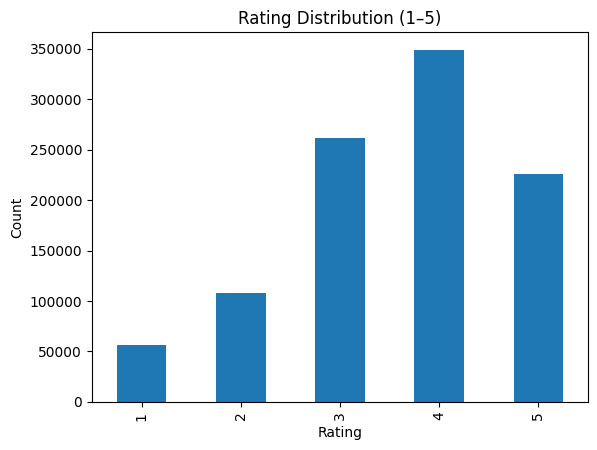

Unique users: 6040
Unique movies: 3706
Total ratings: 1000209
Sparsity: 0.9553


In [19]:
import matplotlib.pyplot as plt

# Rating distribution
plt.figure()
ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution (1–5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Dataset sparsity
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_interactions = len(ratings)
sparsity = 1 - (n_interactions / (n_users * n_movies))

print("Unique users:", n_users)
print("Unique movies:", n_movies)
print("Total ratings:", n_interactions)
print("Sparsity:", round(sparsity, 4))
